<a href="https://colab.research.google.com/github/omendez930/Bank-Fraud-Detection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank Fraud Detection**

# Business Understanding

Objective:

The primary goal of analyzing this dataset is to detect fraudulent bank transactions. Fraudulent activities can cause significant financial losses for banks and customers. By leveraging machine learning and data analysis, we aim to build a model that can distinguish between legitimate and fraudulent transactions in real time.



*   A high-performing fraud detection model that minimizes false positives (legitimate transactions incorrectly flagged as fraud) and false negatives (fraudulent transactions that go undetected).
*   The model should generalize well to unseen data to be deployable in a real-world setting.
*   Business value: reducing financial losses due to fraud and enhancing customer trust in the bank’s security systems.

# Data Understanding

Key Features to Examine:

The dataset contains 200k rows of transactional data labeled as fraudulent or non-fraudulent. Each row represents a transaction with various features describing its characteristics.



1.   Gender: The gender of the consumer (e.G., Male, Female, Other). Four.
2.   Age: The age of the consumer at the time of the transaction.
3.   State: The nation in which the patron resides.
4.   Bank_Branch: The specific financial institution branch wherein the consumer holds their account.
5.   Account_Type: The kind of account held with the aid of the customer (e.G., Savings, Checking). Nine.
6.   Transaction_ID: A particular identifier for each transaction.
7.   Transaction_Date: The date on which the transaction passed off. Eleven.
8.   Transaction_Time: The specific time the transaction became initiated.
9.   Transaction_Amount: The financial value of the transaction.
10.  Merchant_ID: A particular identifier for the merchant worried within the transaction.
11.  Transaction_Type: The nature of the transaction (e.G., Withdrawal, Deposit, Transfer).
12.   Merchant_Category: The class of the merchant (e.G., Retail, Online, Travel).
13.   Account_Balance: The balance of the customer's account after the transaction.
14.   Transaction_Device: The tool utilized by the consumer to perform the transaction (e.G., Mobile, Desktop).
15.   Transaction_Location: The geographical vicinity (e.G., latitude, longitude) of the transaction.
16.   Device_Type: The kind of device used for the transaction (e.G., Smartphone, Laptop).
17.   Is_Fraud: A binary indicator (1 or zero) indicating whether or not the transaction is fraudulent or now not.
18.   Transaction_Currency: The currency used for the transaction (e.G., USD, EUR).
19.   Transaction_Description: A brief description of the transaction (e.G., buy, switch).







In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
 # Download apache spark
!wget https://dlcdn.apache.org/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz

--2025-02-20 01:45:23--  https://dlcdn.apache.org/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388988563 (371M) [application/x-gzip]
Saving to: ‘spark-3.4.4-bin-hadoop3.tgz.2’

spark-3.4.4-bin-had 100%[===================>] 370.97M  32.9MB/s    in 5.9s    

2025-02-20 01:45:55 (63.4 MB/s) - ‘spark-3.4.4-bin-hadoop3.tgz.2’ saved [388988563/388988563]



In [ ]:
!tar -xvf /content/spark-3.4.4-bin-hadoop3.tgz

spark-3.4.4-bin-hadoop3/
spark-3.4.4-bin-hadoop3/jars/
spark-3.4.4-bin-hadoop3/jars/HikariCP-2.5.1.jar
spark-3.4.4-bin-hadoop3/jars/JLargeArrays-1.5.jar
spark-3.4.4-bin-hadoop3/jars/JTransforms-3.1.jar
spark-3.4.4-bin-hadoop3/jars/RoaringBitmap-0.9.38.jar
spark-3.4.4-bin-hadoop3/jars/ST4-4.0.4.jar
spark-3.4.4-bin-hadoop3/jars/activation-1.1.1.jar
spark-3.4.4-bin-hadoop3/jars/aircompressor-0.21.jar
spark-3.4.4-bin-hadoop3/jars/algebra_2.12-2.0.1.jar
spark-3.4.4-bin-hadoop3/jars/annotations-17.0.0.jar
spark-3.4.4-bin-hadoop3/jars/antlr-runtime-3.5.2.jar
spark-3.4.4-bin-hadoop3/jars/antlr4-runtime-4.9.3.jar
spark-3.4.4-bin-hadoop3/jars/aopalliance-repackaged-2.6.1.jar
spark-3.4.4-bin-hadoop3/jars/arpack-3.0.3.jar
spark-3.4.4-bin-hadoop3/jars/arpack_combined_all-0.1.jar
spark-3.4.4-bin-hadoop3/jars/arrow-format-11.0.0.jar
spark-3.4.4-bin-hadoop3/jars/arrow-memory-core-11.0.0.jar
spark-3.4.4-bin-hadoop3/jars/arrow-memory-netty-11.0.0.jar
spark-3.4.4-bin-hadoop3/jars/arrow-vector-11.0.0.jar


In [ ]:
!pip install -q findspark

In [ ]:
!update-alternatives --config java


There are 3 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
  0            /usr/lib/jvm/java-17-openjdk-amd64/bin/java      1711      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
  2            /usr/lib/jvm/java-17-openjdk-amd64/bin/java      1711      manual mode
* 3            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 3


In [ ]:
!find / -type d -name "spark-*" 2>/dev/null


/content/spark-3.4.4-bin-hadoop3


In [ ]:
# Set Envrionment Variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java"
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"


In [ ]:
# Initialize findspark
import findspark
from pyspark.sql import SparkSession
findspark.init("/content/spark-3.4.4-bin-hadoop3")

# Create a Pyspark session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark version
print("Spark version:", spark.version)
# spark

PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

In [1]:
!kaggle datasets download -d orangelmendez/bank-fraud

Dataset URL: https://www.kaggle.com/datasets/orangelmendez/bank-fraud
License(s): other
bank-fraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip bank-fraud.zip -d data

Archive:  bank-fraud.zip
replace data/new_bank_fraud_detection.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/new_bank_fraud_detection.csv  


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import classification_report, roc_auc_score, classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
bank_df = pd.read_csv('./data/new_bank_fraud_detection.csv', encoding='utf-8', index_col=0)
bank_df.head()

,Gender,Age,State,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,Transaction_Time,Transaction_Amount,Merchant_ID,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Transaction_Description
0,Male,60,Kerala,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,16:04:07,32415.45,214e03c5-5c34-40d1-a66c-f440aa2bbd02,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,Bitcoin transaction
1,Female,51,Maharashtra,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,17:14:53,43622.60,f9e3f11f-28d3-4199-b0ca-f225a155ede6,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,Grocery delivery
2,Male,20,Bihar,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,03:09:52,63062.56,97977d83-5486-4510-af1c-8dada3e1cfa0,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,Mutual fund investment
3,Female,57,Tamil Nadu,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,12:27:02,14000.72,f45cd6b3-5092-44d0-8afb-490894605184,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,Food delivery
4,Female,43,Punjab,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,18:30:46,18335.16,70dd77dd-3b00-4b2c-8ebc-cfb8af5f6741,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,Debt repayment


In [3]:
bank_df.describe()

,Age,Transaction_Amount,Account_Balance,Is_Fraud
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,44.015110,49538.015554,52437.988784,0.050440
std,15.288774,28551.874004,27399.507128,0.218852
min,18.000000,10.290000,5000.820000,0.000000
25%,31.000000,24851.345000,28742.395000,0.000000
50%,44.000000,49502.440000,52372.555000,0.000000
75%,57.000000,74314.625000,76147.670000,0.000000
max,70.000000,98999.980000,99999.950000,1.000000


In [4]:
bank_df.columns

Index(['Gender', 'Age', 'State', 'Bank_Branch', 'Account_Type',
       'Transaction_ID', 'Transaction_Date', 'Transaction_Time',
       'Transaction_Amount', 'Merchant_ID', 'Transaction_Type',
       'Merchant_Category', 'Account_Balance', 'Transaction_Device',
       'Transaction_Location', 'Device_Type', 'Is_Fraud',
       'Transaction_Currency', 'Transaction_Description'],
      dtype='object')

In [5]:
bank_df.drop(columns=['Gender', 'Age'], inplace=True)

In [6]:
bank_df.isnull().sum()

,0
State,0
Bank_Branch,0
Account_Type,0
Transaction_ID,0
Transaction_Date,0
Transaction_Time,0
Transaction_Amount,0
Merchant_ID,0
Transaction_Type,0
Merchant_Category,0


In [7]:
bank_df.dtypes

,0
State,object
Bank_Branch,object
Account_Type,object
Transaction_ID,object
Transaction_Date,object
Transaction_Time,object
Transaction_Amount,float64
Merchant_ID,object
Transaction_Type,object
Merchant_Category,object


Let's combine the "Transaction_Date" and "Transaction_Time" columns together, and convert it into a datetime dtype.

In [8]:
bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_Date']+" "+bank_df['Transaction_Time'])
bank_df[['Transaction_Date','Transaction_Time']]

bank_df.dtypes

<ipython-input-8-02d4b654fe3d>:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_Date']+" "+bank_df['Transaction_Time'])


,0
State,object
Bank_Branch,object
Account_Type,object
Transaction_ID,object
Transaction_Date,object
Transaction_Time,object
Transaction_Amount,float64
Merchant_ID,object
Transaction_Type,object
Merchant_Category,object


In [9]:
bank_df.head()

,State,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,Transaction_Time,Transaction_Amount,Merchant_ID,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Transaction_Description,Transaction_DateTime
0,Kerala,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,16:04:07,32415.45,214e03c5-5c34-40d1-a66c-f440aa2bbd02,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,Bitcoin transaction,2025-01-23 16:04:07
1,Maharashtra,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,17:14:53,43622.60,f9e3f11f-28d3-4199-b0ca-f225a155ede6,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,Grocery delivery,2025-01-11 17:14:53
2,Bihar,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,03:09:52,63062.56,97977d83-5486-4510-af1c-8dada3e1cfa0,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,Mutual fund investment,2025-01-25 03:09:52
3,Tamil Nadu,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,12:27:02,14000.72,f45cd6b3-5092-44d0-8afb-490894605184,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,Food delivery,2025-01-19 12:27:02
4,Punjab,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,18:30:46,18335.16,70dd77dd-3b00-4b2c-8ebc-cfb8af5f6741,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,Debt repayment,2025-01-30 18:30:46


In [10]:
#convert the Transaction Date to Date
bank_df = bank_df.drop(columns=['Transaction_Date','Transaction_Time'], axis=1)
bank_df.dtypes

,0
State,object
Bank_Branch,object
Account_Type,object
Transaction_ID,object
Transaction_Amount,float64
Merchant_ID,object
Transaction_Type,object
Merchant_Category,object
Account_Balance,float64
Transaction_Device,object


In [11]:
bank_df.columns

Index(['State', 'Bank_Branch', 'Account_Type', 'Transaction_ID',
       'Transaction_Amount', 'Merchant_ID', 'Transaction_Type',
       'Merchant_Category', 'Account_Balance', 'Transaction_Device',
       'Transaction_Location', 'Device_Type', 'Is_Fraud',
       'Transaction_Currency', 'Transaction_Description',
       'Transaction_DateTime'],
      dtype='object')

# **Exploratory Data Analysis**

## **Visualizations**

We'll start with some descriptive statistics. We'll visualize the distribution of fraudulent transactions that occur within the data. This shows the class distribution and helps you check if the data is imbalanced.

Next, lets check the distribution of Transaction Amounts. This helps visualize the distribution of transaction amounts and understand any skewness.

## **Fraud Distribution**

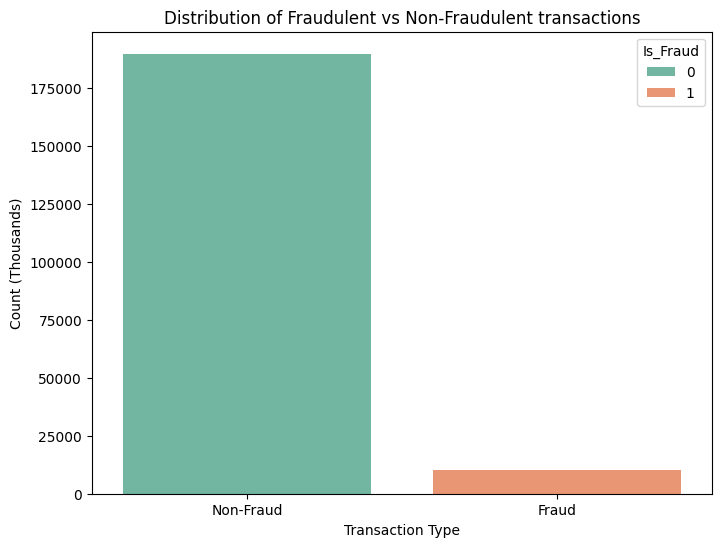

In [12]:
plt.figure(figsize=(8,6))
sns.countplot(x='Is_Fraud', data=bank_df, palette='Set2', hue='Is_Fraud')
plt.title('Distribution of Fraudulent vs Non-Fraudulent transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count (Thousands)')
plt.xticks([0,1], ['Non-Fraud','Fraud'])
plt.show()


## **Distribution of Transaction Amounts**

This scatterplot can help assess if there's a relationship between the transaction amount and whether the transaction is fraudulent or not.

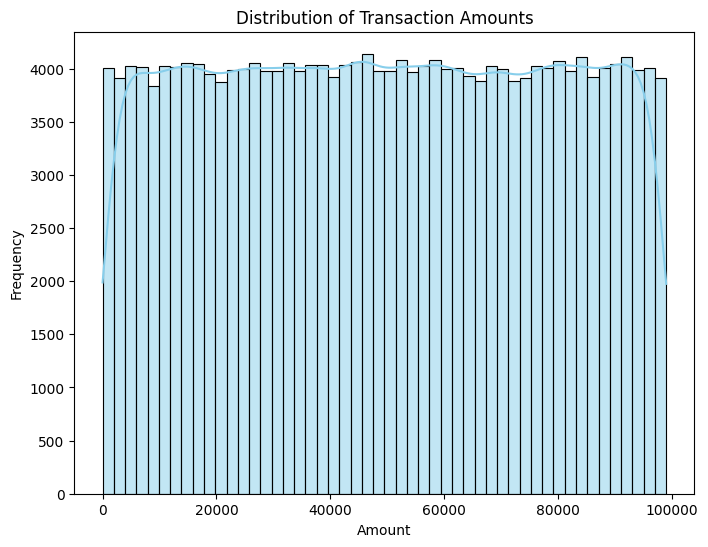

In [13]:
plt.figure(figsize=(8,6))
sns.histplot(bank_df['Transaction_Amount'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


<ipython-input-14-23353bec0a7c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Is_Fraud', y='Transaction_Amount', data=bank_df, palette='Set2')


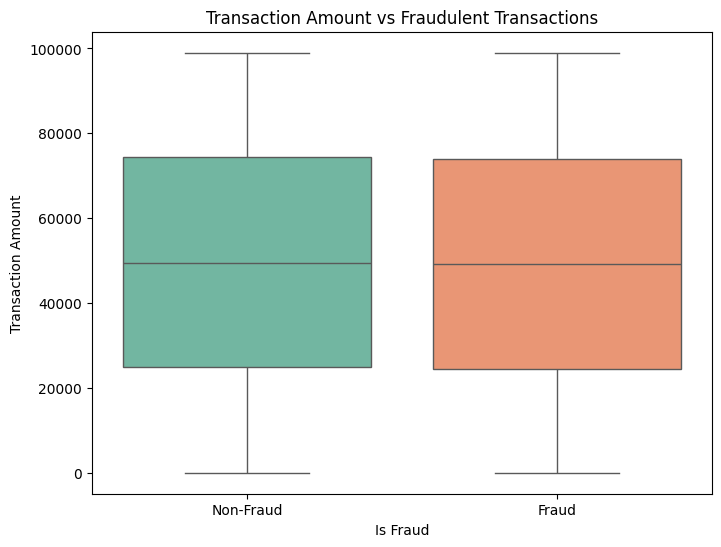

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Is_Fraud', y='Transaction_Amount', data=bank_df, palette='Set2')
plt.title('Transaction Amount vs Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

## **Fraud by Transaction Type**

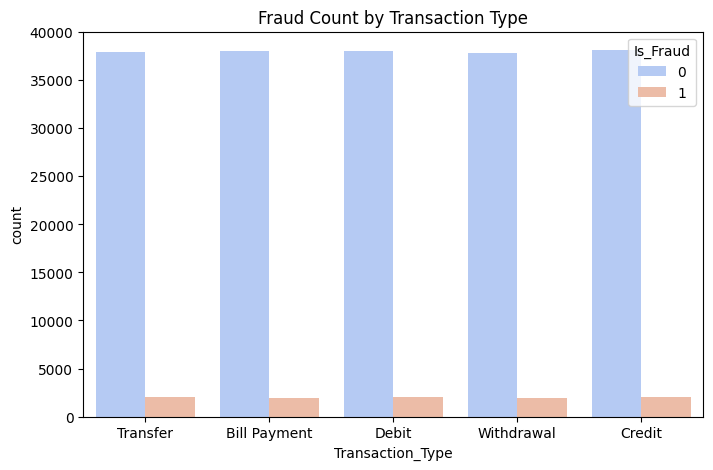

In [15]:
plt.figure(figsize=(8,5))
sns.countplot(data=bank_df, x='Transaction_Type', hue='Is_Fraud', palette='coolwarm')
plt.title("Fraud Count by Transaction Type")
plt.show()

## **Time-Based Analysis**

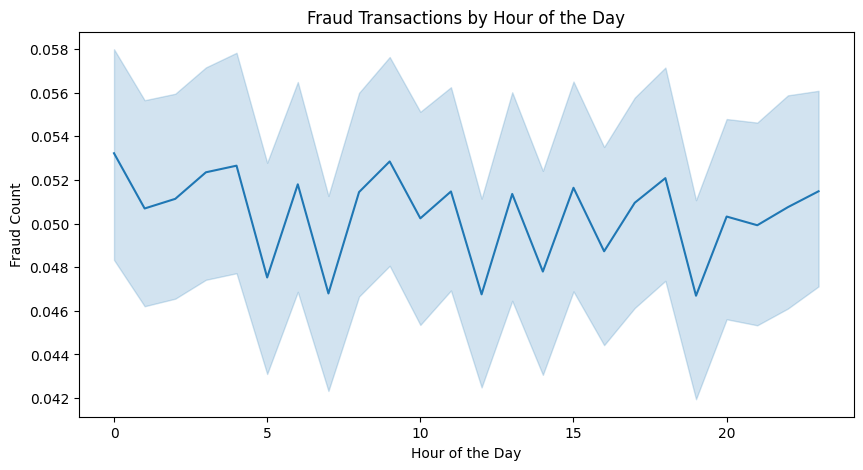

In [16]:
if 'Transaction_DateTime' in bank_df.columns:
    bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_DateTime'])
    bank_df.set_index('Transaction_DateTime', inplace=True)
    bank_df['hour'] = bank_df.index.hour

    plt.figure(figsize=(10,5))
    sns.lineplot(x=bank_df['hour'], y=bank_df['Is_Fraud'])
    plt.title("Fraud Transactions by Hour of the Day")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Fraud Count")
    plt.show()


## **Convert Datetime Features**

In [23]:
# if 'Transaction_DateTime' in bank_df.columns:
#     bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_DateTime'])
#     bank_df['Transaction_Hour'] = bank_df['Transaction_DateTime'].dt.hour
#     bank_df['Transaction_Day'] = bank_df['Transaction_DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
#     bank_df.drop(columns=['Transaction_date', 'Transaction_time'], inplace=True)  # Drop original timestamp
# bank_df.head()

,State,Bank_Branch,Account_Type,Transaction_ID,Transaction_Amount,Merchant_ID,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Transaction_Description,hour
Transaction_DateTime,,,,,,,,,,,,,,,,
2025-01-23 16:04:07,Kerala,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,32415.45,214e03c5-5c34-40d1-a66c-f440aa2bbd02,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,Bitcoin transaction,16
2025-01-11 17:14:53,Maharashtra,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,43622.60,f9e3f11f-28d3-4199-b0ca-f225a155ede6,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,Grocery delivery,17
2025-01-25 03:09:52,Bihar,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,63062.56,97977d83-5486-4510-af1c-8dada3e1cfa0,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,Mutual fund investment,3
2025-01-19 12:27:02,Tamil Nadu,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,14000.72,f45cd6b3-5092-44d0-8afb-490894605184,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,Food delivery,12
2025-01-30 18:30:46,Punjab,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,18335.16,70dd77dd-3b00-4b2c-8ebc-cfb8af5f6741,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,Debt repayment,18


In [17]:
categorical_columns = bank_df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['State', 'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Merchant_ID', 'Transaction_Type', 'Merchant_Category', 'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Transaction_Currency', 'Transaction_Description']


In [18]:
# Define feature matrix (X) and target variable (y)

X = bank_df.drop(columns=['Is_Fraud'])
y = bank_df['Is_Fraud']

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)

In [19]:
bank_df

,State,Bank_Branch,Account_Type,Transaction_ID,Transaction_Amount,Merchant_ID,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Transaction_Description,hour
Transaction_DateTime,,,,,,,,,,,,,,,,
2025-01-23 16:04:07,Kerala,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,32415.45,214e03c5-5c34-40d1-a66c-f440aa2bbd02,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,Bitcoin transaction,16
2025-01-11 17:14:53,Maharashtra,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,43622.60,f9e3f11f-28d3-4199-b0ca-f225a155ede6,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,Grocery delivery,17
2025-01-25 03:09:52,Bihar,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,63062.56,97977d83-5486-4510-af1c-8dada3e1cfa0,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,Mutual fund investment,3
2025-01-19 12:27:02,Tamil Nadu,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,14000.72,f45cd6b3-5092-44d0-8afb-490894605184,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,Food delivery,12
2025-01-30 18:30:46,Punjab,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,18335.16,70dd77dd-3b00-4b2c-8ebc-cfb8af5f6741,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,Debt repayment,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-08 18:42:09,Dadra and Nagar Haveli and Daman and Diu,Diu Branch,Business,8d856bc7-4666-4509-a067-48d67500694a,98513.74,72817d4a-830b-4d16-bf74-244dccfe4cc4,Credit,Restaurant,37475.11,Desktop/Laptop,"Diu, Dadra and Nagar Haveli and Daman and Diu",ATM,0,INR,ATM withdrawal,18
2025-01-01 20:51:21,Manipur,Kangpokpi Branch,Business,f2890dbd-4e01-445d-97f5-ac56886e9037,40593.55,087718f9-1faa-44ef-b162-24d20ddc903c,Withdrawal,Groceries,53037.20,ATM,"Kangpokpi, Manipur",ATM,0,INR,Subscription box,20
2025-01-28 10:47:40,Chandigarh,Chandigarh Branch,Savings,f714b758-7539-474d-b676-5fa7e2480141,61579.70,a313cfbc-ef3d-4e59-8347-a948ac292a6f,Withdrawal,Health,96225.36,ATM,"Chandigarh, Chandigarh",Desktop,0,INR,Charity donation,10


## **Train a Classification Model**

## Baseline Model

I'll start by creating a baseline LogisticRegression model. I'll start by Standardizing the categorical columns and Numberical columns.

Once standaridized, I will create a pipeline that creates a baseline model.

In [20]:
print(y_train.value_counts(normalize=True))

Is_Fraud
0    0.949562
1    0.050438
Name: proportion, dtype: float64


### **Model the pipeline**

In [23]:
# Identify numerical & categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(exclude=['object']).columns.tolist()

# Apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns),  # Categorical encoding
        ('num', StandardScaler(), numerical_columns)  # Scale numerical columns
    ],
    remainder='passthrough'  # Keep all columns not explicitly transformed
)

logreg_pipeline = Pipeline([
    ('preprocesson', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=33))
])

logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))


[[37982     0]
 [ 2018     0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37982
           1       1.00      0.00      0.00      2018

    accuracy                           0.95     40000
   macro avg       0.97      0.50      0.49     40000
weighted avg       0.95      0.95      0.92     40000



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


As shown earlier the dataset is imbalanced between counts that were considered to be fraudulent and counts that were not. Let's use XGBoost to address imblance. It's one of the best classifiers for this type of issue and works well for fraud detection

In [24]:
# Create XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective="binary:logistic",
                                  eval_metric="auc",
                                  scale_pos_weight=5,  # Increase this (try values between 5-10)
                                  use_label_encoder=True,
                                  random_state=33
                                 ))
])

# Define hyperparameters for tuning
xgb_params = {
    'classifier__n_estimators': [5,10],
    'classifier__max_depth': [3,6],
    'classifier__learning_rate': [0.01, 0.1]
}

#Grid Search for best parameters
xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=3, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Best Model Performance
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred_xgb, zero_division=1))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:07:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[[37982     0]
 [ 2018     0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37982
           1       0.00      0.00      0.00      2018

    accuracy                           0.95     40000
   macro avg       0.47      0.50      0.49     40000
weighted avg       0.90      0.95      0.92     40000



In [25]:
# Create Random Forest pipeline
'''Since RandomForestCLassifier is not as effective with imbalanced data, we will perform SMOTE on the target and see if we get better results.'''
# Wnsure y_train is a numpy Array
y_train = np.array(y_train)


# Apple preprocessing first
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Count classes for SMOTE
subset_count = pd.Series(y_train).value_counts()
minority_count = subset_count[1]

# double the minory count
target_minority_count = minority_count * 2

# Apply SMOTE before Pipeline (Avoids data leakage)
smote = SMOTE(sampling_strategy={1: target_minority_count}, random_state=33)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# RandomForest Pipeline
rf_pipeline =  ImbPipeline([
    ('classifier', RandomForestClassifier(n_estimators=10,
                                          class_weight='balanced',
                                          random_state=33,
                                          max_depth=None))
])

rf_params = {
    'classifier__n_estimators': [5, 10],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2,5]
}

# Grisd Search for best parameters
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_resampled, y_train_resampled)


# Ensure y_test is a Numpy Array
y_test = np.array(y_test)

# Evaluate best model
y_pred_rf = rf_grid.best_estimator_.predict(X_test_encoded)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=1))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[[37807   175]
 [ 2013     5]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37982
           1       0.03      0.00      0.00      2018

    accuracy                           0.95     40000
   macro avg       0.49      0.50      0.49     40000
weighted avg       0.90      0.95      0.92     40000



### Evaluating the Model on Test Data
Since we have an imbalanced classification probelm, accuracy is not enough to determine the models efficiency.

Let's print what precision, recall, and f1 provide.

In [26]:
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred_rf)}')
print(f'Precision: {precision_score(y_test, y_pred_rf)}')
print(f'Recall: {recall_score(y_test, y_pred_rf)}')
print(f'F1 Score: {f1_score(y_test, y_pred_rf)}')

ROC-AUC Score: 0.4989351275308073
Precision: 0.027777777777777776
Recall: 0.002477700693756194
F1 Score: 0.004549590536851683


In [27]:
print(f'Best Parameters: {rf_grid.best_params_}')
print(f'Best F1-Score: {rf_grid.best_score_}')

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 5}
Best F1-Score: 0.5118602960007714


In [ ]:
best_rf_model = rf_grid.best_estimator_.named_steps['classifier']
feature_importances = best_rf_model.feature_importances_

#get feature names
feature_name = preprocessor.get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# plot
plt.figure(figsize=(10,6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), np.array(feature_name)[sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()


### Feature importance Analysis

Understanding what features drive fraud detection helps in model interpretability

In [ ]:
importances = rf_grid.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel("Importance Score")
plt.title("Top 10 Features in Fraud Detection")
plt.show()


## **Time series Forecasting**

Let's split the dataset by time rather than randomly.

In [21]:
bank_df = bank_df.sort_values(by='Transaction_DateTime')  # Ensure data is in time order
bank_df.head()

,State,Bank_Branch,Account_Type,Transaction_ID,Transaction_Amount,Merchant_ID,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Transaction_Description,hour
Transaction_DateTime,,,,,,,,,,,,,,,,
2025-01-01 00:00:49,Mizoram,Champhai Branch,Business,5eda3d4d-224f-41d6-9d9b-4245a296245e,75457.97,cf07e07a-9b63-4fac-a1c9-f8e525911ce0,Credit,Electronics,29266.04,Smart Card,"Champhai, Mizoram",Desktop,0,INR,Movie tickets,0
2025-01-01 00:00:53,Mizoram,Lunglei Branch,Business,7803c75d-9ec4-4b1c-beb1-948d5e526ad1,97456.90,f9b56aac-fa1a-4af8-839f-97653d707b5b,Bill Payment,Restaurant,55837.42,Payment Gateway Device,"Lunglei, Mizoram",Desktop,0,INR,Utility bill payment,0
2025-01-01 00:00:57,Gujarat,Bhavnagar Branch,Business,55879ea5-e3b0-404e-9720-69675ca29d7d,19944.60,9f4524bf-7539-4373-9cca-f6189603e121,Debit,Electronics,91268.75,Smart Card,"Bhavnagar, Gujarat",POS,0,INR,School fee payment,0
2025-01-01 00:01:15,Arunachal Pradesh,Ziro Branch,Checking,8884bccf-b06d-472f-a521-547d1c75a7e6,91920.78,83f97b35-cdd4-4f79-b840-880fd4eb392d,Debit,Groceries,91288.06,Self-service Banking Machine,"Ziro, Arunachal Pradesh",Desktop,0,INR,Bill payment,0
2025-01-01 00:01:35,Andaman and Nicobar Islands,Diglipur Branch,Business,33b96467-da85-4c8b-bf6f-45e6991d08f0,94655.64,194b8027-6d92-49c1-9178-f223e9181c5c,Debit,Clothing,74219.97,POS Mobile App,"Diglipur, Andaman and Nicobar Islands",POS,0,INR,Streaming subscription,0


In [22]:
train_size = int(0.8 * len(bank_df))
train, test = bank_df.iloc[:train_size], bank_df.iloc[train_size:]

X_train_time, y_train_time = train.drop(columns=['Is_Fraud']), train['Is_Fraud']
X_test_time, y_test_time = test.drop(columns=['Is_Fraud']), test['Is_Fraud']


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


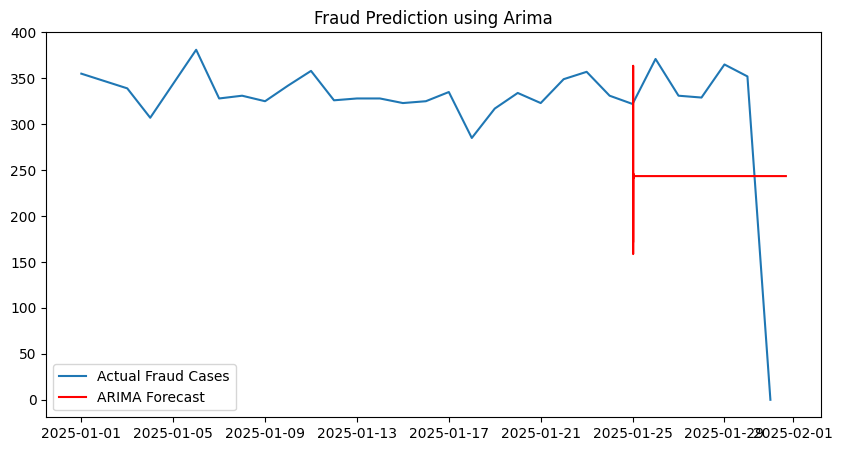

In [24]:
from statsmodels.tsa.arima.model import ARIMA

# # Esure 'Transaction_DATETIME column is set to index
# bank_df.set_index('Transaction_DateTime', inplace=True)

#Aggregate fraud counts over time
fraud_counts = bank_df.resample('D')['Is_Fraud'].sum()

# Train ARIMA model
model = ARIMA(fraud_counts[:train_size], order=(5,1,0))
model_fit = model.fit()

# forecast future fraud cases
forecast = model_fit.forecast(steps=len(test))

# plot results
plt.figure(figsize=(10,5))
plt.plot(fraud_counts, label='Actual Fraud Cases')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('Fraud Prediction using Arima')
plt.show()